In [1]:
# 忽略warnings
import warnings 
warnings.filterwarnings('ignore') 

# 导入系统库
import os

# 强制使用CPU
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

# 导入Python通用库
import matplotlib.pyplot as plt
import numpy as np

# 导入TF 2.0并设置GPU
import tensorflow as tf
# 导入Keras库
from tensorflow import keras
# 设置使用GPU显存的比例
from keras.backend.tensorflow_backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.6
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config)) 

# 导入util模块的各种方法
# from keras.utils.np_utils import to_categorical
# 导入数据集
from tensorflow.keras.datasets import imdb
# 导入模型、优化器、损失函数等等
from tensorflow.keras import preprocessing
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import layers
# 导入Keras字符处理模块
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
# 导入预训练模型
# from keras.applications import VGG16

Using TensorFlow backend.


# 06. 深度学习用于文本和序列
本章将介绍使用深度学习模型处理文本、时间序列和一般的序列数据。用于处理序列的两种基本的深度学习算法分别是`循环神经网络`（recurrent neural network）和`一维卷积神经网络`（1D convnet），后者是上一章介绍的二维卷积神经网络的一维版本。本章将讨论这两种方法。

这些算法的应用包括：
+ 文档分类和时间序列分类，比如识别文章的主题或书的作者
+ 时间序列对比，比如估测两个文档或两支股票行情的相关程度
+ 序列到序列的学习，比如将英语翻译成法语
+ 情感分析，比如将推文或电影评论的情感划分为正面或负面
+ 时间序列预测，比如根据某地最近的天气数据来预测未来天气

## 6.1 处理文本数据
文本是最常用的序列数据之一，可以理解为字符序列或单词序列，但最常见的是单词级处理。后面几节介绍的深度学习序列处理模型都可以根据文本生成基本形式的自然语言理解，并可用于文档分类、情感分析、作者识别甚至问答等应用。

> **注意**
> 本章的这些深度学习模型都没有像人类一样真正地理解文本，而只是映射出书面语言的统计结构，但这足以解决许多简单的文本任务。深度学习用于自然语言处理是将模式识别应用于单词、句子和段落，这与计算机视觉是将模式识别应用于像素大致相同

与其他所有神经网络一样，深度学习模型不会接收原始文本作为输入，它只能处理数值张量。`文本向量化`（vectorize）是指将文本转换为数值张量的过程。它有多种实现方法：
+ 将文本分割为单词，并将每个单词转换为一个向量
+ 将文本分割为字符，并将每个字符转换为一个向量
+ 提取单词或字符的`n-gram`，并将每个`n-gram`转换为一个向量。`n-gram`是多个连续单词或字符的集合（`n-gram`之间可重叠）

将文本分解而成的单元（单词、字符或`n-gram`）叫作`标记`（token），将文本分解成标记的过程叫作`分词`（tokenization）。所有文本向量化过程都是应用某种分词方案，然后将数值向量与生成的标记相关联。这些向量组合成序列张量，被输入到深度神经网络中（见`图6-1`）。

<img src="images/06_01.png" style="width:400px;"/>

将向量与标记相关联的方法有很多种。本节将介绍两种主要方法：
+ **one-hot编码**
+ **标记嵌入**：即`token embedding`，通常只用于单词，叫作`词嵌入`（`word embedding`）

本节剩余内容将解释这些方法，并介绍如何使用这些方法，将原始文本转换为可以输入到`Keras`网络中的`Numpy`张量。

> **理解n-gram和词袋**
> 
> `n-gram`是从一个句子中提取的N个（或更少）连续单词的集合。这一概念中的“单词”也可以替换为“字符”。
> 
> 下面来看一个简单的例子。考虑句子“The cat sat on the mat.”（“猫坐在垫子上”）。它可以被分解为以下二元语法（2-grams）的集合：
> ```python
> {"The", "The cat", "cat", "cat sat", "sat", "sat on", "on", "on the", "the", "the mat", "mat"}
> ```
> 这个句子也可以被分解为以下三元语法（3-grams）的集合：
> ```python
> {"The", "The cat", "cat", "cat sat", "The cat sat", "sat", "sat on", "on", "cat sat on", "on the", "the", "sat on the", "the mat", "mat", "on the mat"}
> ```
> 这样的集合分别叫作`二元语法袋`（bag-of-2-grams）及`三元语法袋`（bag-of-3-grams）。`袋`（bag）指的是，我们处理的是标记组成的集合，而不是一个列表或序列，即标记没有特定的顺序。这一系列分词方法叫作`词袋`（bag-of-words）。
> 
> 词袋是一种不保存顺序的分词方法（生成的标记组成一个集合，而不是一个序列，舍弃了句子的总体结构），因此它往往被用于浅层的语言处理模型，而不是深度学习模型。提取`n-gram`是一种特征工程，深度学习不需要这种死板而又不稳定的方法，并将其替换为分层特征学习。本章后面将介绍的一维卷积神经网络和循环神经网络，都能够通过观察连续的单词序列或字符序列来学习单词组和字符组的数据表示，而无须明确知道这些组的存在。因此，本书不会进一步讨论`n-gram`。但一定要记住，在使用轻量级的浅层文本处理模型时（比如`logistic回归`和`随机森林`），`n-gram`是一种功能强大、不可或缺的特征工程工具。

### 6.1.1 单词和字符的one-hot编码
`one-hot`编码是将标记转换为向量的最常用、最基本的方法。我们在第3章的IMDB和路透社两个例子中已经用过这种方法（都是处理单词）。

当然，也可以进行字符级的`one-hot`编码。下面两个简单示例，一个是单词级的`one-hot`编码，另一个是字符级的`one-hot`编码。

首先是单词级的`one-hot`编码：

In [2]:
# 初始数据：每个样本是列表的一个元素（本例中的样本是一个句子，但也可以是一整篇文档）
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# 构建数据中所有标记的索引
token_index = {}
for sample in samples:
    # 利用split方法对样本进行分词。在实际应用中，还需要从样本中去掉标点和特殊字符
    for word in sample.split():
        if word not in token_index:
            # 为每个唯一单词指定一个唯一索引。注意，没有为索引编号0指定单词
            token_index[word] = len(token_index) + 1
            
# 对样本进行分词。只考虑每个样本前`max_length`个单词
max_length = 10

# 将结果保存在results中
results = np.zeros((len(samples), max_length, max(token_index.values()) + 1))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1.

下面是字符级的`one-hot`编码：

In [3]:
import string

samples = ['The cat sat on the mat.', 'The dog ate my homework.']
# 所有可打印的ASCII字符
characters = string.printable
token_index = dict(zip(characters, range(1, len(characters) + 1)))
# 设置最大长度
max_length = 50
results = np.zeros((len(samples), max_length, max(token_index.values()) + 1))
for i, sample in enumerate(samples):
    for j, character in enumerate(sample[:max_length]):
        index = token_index.get(character)
        results[i, j, index] = 1.

注意，`Keras`的内置函数可以对原始文本数据进行单词级或字符级的`one-hot`编码。你应该使用这些函数，因为它们实现了许多重要的特性，比如从字符串中去除特殊字符、只考虑数据集中前N个最常见的单词（这是一种常用的限制，以避免处理非常大的输入向量空间）。

In [4]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.']
# 创建一个分词器（tokenizer），设置为只考虑前1000个最常见的单词
tokenizer = Tokenizer(num_words=1000)
# 构建单词索引
tokenizer.fit_on_texts(samples)
# 将字符串转换为整数索引组成的列表
sequences = tokenizer.texts_to_sequences(samples) 
# 也可以直接得到one-hot二进制表示。这个分词器也支持除one-hot编码外的其他向量化模式
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')
# 找回单词索引
word_index = tokenizer.word_index
('Found %s unique tokens.' % len(word_index))

'Found 9 unique tokens.'

`one-hot`编码的一种变体是所谓的`one-hot`散列技巧（one-hot hashing trick），如果词表中唯一标记的数量太大而无法直接处理，就可以使用这种技巧。这种方法没有为每个单词显式分配一个索引并将这些索引保存在一个字典中，而是将单词散列编码为固定长度的向量，通常用一个非常简单的散列函数来实现。这种方法的主要优点在于，它避免了维护一个显式的单词索引，从而节省内存并允许数据的在线编码（在读取完所有数据之前，你就可以立刻生成标记向量）。这种方法有一个缺点，就是可能会出现散列冲突，即两个不同的单词可能具有相同的散列值，随后任何机器学习模型观察这些散列值，都无法区分它们所对应的单词。如果散列空间的维度远大于需要散列的唯一标记的个数，散列冲突的可能性会减小。

In [5]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.']
# 将单词保存为长度为1000的向量。如果单词数量接近1000个（或更多），
# 那么会遇到很多散列冲突，这会降低这种编码方法的准确性
dimensionality = 1000
# 设置单词最大长度
max_length = 10
results = np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        # 将单词散列为0~1000范围内的一个随机整数索引
        index = abs(hash(word)) % dimensionality
        results[i, j, index] = 1.

### 6.1.2 使用词嵌入
将单词与向量相关联还有另一种常用的强大方法，就是使用密集的`词向量`（word vector），也叫`词嵌入`（word embedding）。`one-hot`编码得到的向量是二进制的、稀疏的、维度很高的，而词嵌入是低维的浮点数向量（即密集向量，与稀疏向量相对），参见`图6-2`。与`one-hot`编码得到的词向量不同，词嵌入是从数据中学习得到的。常见的词向量维度是256、512或1024（处理非常大的词表时）。与此相对，`one-hot`编码的词向量维度通常为20000或更高（对应包含20000个标记的词表）。因此，词向量可以将更多的信息塞入更低的维度中。

<img src="images/06_02.png" style="width:500px;"/>

获取词嵌入有两种方法：
+ 在完成主任务（比如文档分类或情感预测）的同时学习词嵌入。在这种情况下，一开始是随机的词向量，然后对这些词向量进行学习，其学习方式与学习神经网络的权重相同
+ 在不同于待解决问题的机器学习任务上预计算好词嵌入，然后将其加载到模型中。这些词嵌入叫作`预训练词嵌入`（pretrained word embedding）

我们来分别看一下这两种方法。

##### 1. 利用Embedding层学习词嵌入
要将一个词与一个密集向量相关联，最简单的方法就是随机选择向量。这种方法的问题在于，得到的嵌入空间没有任何结构。例如，`accurate`和`exact`两个词的嵌入可能完全不同，尽管它们在大多数句子里都是可以互换的。深度神经网络很难对这种杂乱的、非结构化的嵌入空间进行学习。

说得更抽象一点，词向量之间的几何关系应该表示这些词之间的语义关系。词嵌入的作用应该是将人类的语言映射到几何空间中。例如，在一个合理的嵌入空间中，同义词应该被嵌入到相似的词向量中，一般来说，任意两个词向量之间的几何距离（比如L2距离）应该和这两个词的语义距离有关（表示不同事物的词被嵌入到相隔很远的点，而相关的词则更加靠近）。除了距离，你可能还希望嵌入空间中的特定方向也是有意义的。为了更清楚地说明这一点，我们来看一个具体示例。

在`图6-3`中，四个词被嵌入在二维平面上，这四个词分别是`cat`、`dog`、`wolf`和`tiger`。对于我们这里选择的向量表示，这些词之间的某些语义关系可以被编码为几何变换。例如，从`cat`到`tiger`的向量与从`dog`到`wolf`的向量相等，这个向量可以被解释为`从宠物到野生动物`向量。同样，从`dog`到`cat`的向量与从`wolf`到`tiger`的向量也相等，它可以被解释为`从犬科到猫科`向量。

<img src="images/06_03.png" style="width:250px;"/>

在真实的词嵌入空间中，常见的有意义的几何变换的例子包括`性别`向量和`复数`向量。例如，将`king`向量加上`female`向量，得到的是`queen`向量。将`king`向量加上`plural`向量，得到的是`kings`向量。词嵌入空间通常具有几千个这种可解释的、并且可能很有用的向量。

有没有一个理想的词嵌入空间，可以完美地映射人类语言，并可用于所有自然语言处理任务？可能有，但我们尚未发现。此外，也不存在人类语言（human language）这种东西。世界上有许多种不同的语言，而且它们不是同构的，因为语言是特定文化和特定环境的反射。但从更实际的角度来说，一个好的词嵌入空间在很大程度上取决于你的任务。英语电影评论情感分析模型的完美词嵌入空间，可能不同于英语法律文档分类模型的完美词嵌入空间，因为某些语义关系的重要性因任务而异。

因此，合理的做法是对每个新任务都学习一个新的嵌入空间。幸运的是，反向传播让这种学习变得很简单，而`Keras`使其变得更简单。我们要做的就是学习一个层的权重，这个层就是`Embedding`层。

In [6]:
# Embedding层至少需要两个参数：
# * 标记的个数（这里是1000，即最大单词索引+1）
# * 嵌入的维度（这里是64）
embedding_layer = Embedding(1000, 64)

最好将`Embedding`层理解为一个字典，将整数索引（表示特定单词）映射为密集向量。它接收整数作为输入，并在内部字典中查找这些整数，然后返回相关联的向量。`Embedding`层实际上是一种字典查找（见`图6-4`）。

<img src="images/06_04.png" style="width:350px;"/>

`Embedding`层的输入是一个二维整数张量，其形状为`(samples, sequence_length)`，每个元素是一个整数序列。它能够嵌入长度可变的序列，例如，对于前一个例子中的`Embedding`层，你可以输入形状为`(32, 10)`（32个长度为10的序列组成的批量）或`(64, 15)`（64个长度为15的序列组成的批量）的批量。不过一批数据中的所有序列必须具有相同的长度（因为需要将它们打包成一个张量），所以较短的序列应该用0填充，较长的序列应该被截断。

这个`Embedding`层返回一个形状为`(samples, sequence_length, embedding_dimensionality)`的三维浮点数张量。然后可以用`RNN`层或一维卷积层来处理这个三维张量。

将一个`Embedding`层实例化时，它的权重（即标记向量的内部字典）最开始是随机的，与其他层一样。在训练过程中，利用反向传播来逐渐调节这些词向量，改变空间结构以便下游模型可以利用。一旦训练完成，嵌入空间将会展示大量结构，这种结构专门针对训练模型所要解决的问题。

我们将这个想法应用于你熟悉的`IMDB`电影评论情感预测任务。首先，我们需要快速准备数据。将电影评论限制为前10000个最常见的单词，然后将评论长度限制为只有20个单词。对于这10000个单词，网络将对每个词都学习一个8维嵌入，将输入的整数序列（二维整数张量）转换为嵌入序列（三维浮点数张量），然后将这个张量展平为二维，最后在上面训练一个`Dense`层用于分类。

In [7]:
# 作为特征的单词个数
max_features = 10000
# 在这么多单词后截断文本（这些单词都属于前max_features个最常见的单词）
maxlen = 20
# 将数据加载为整数列表
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features) 
("原始数据尺寸：", x_train.shape)

('原始数据尺寸：', (25000,))

In [8]:
# 将整数列表转换成形状为(samples, maxlen)的二维整数张量
# x_train原来的结构为包含25000个list的数字，即array[list]
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)
("转换后数据尺寸：", x_train.shape)

('转换后数据尺寸：', (25000, 20))

在`IMDB`数据上使用`Embedding`层和分类器：

In [9]:
model = Sequential()
# 指定Embedding层的最大输入长度，以便后面将嵌入输入展平
# Embedding层激活的形状为(samples, maxlen, 8)
model.add(Embedding(10000, 8, input_length=maxlen))
# 将三维的嵌入张量展平成形状为(samples, maxlen * 8)的二维张量
model.add(Flatten())
# 在上面添加分类器
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten (Flatten)            (None, 160)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 2s 79us/sample - loss: 0.6780 - acc: 0.5974 - val_loss: 0.6425 - val_acc: 0.6828
Epoch 2/10
20000/20000 [==============================] - 1s 57us/sample - loss: 0.5642 - acc: 0.7423 - val_loss: 0.5408 - val_acc: 0.7272
Epoch 3/10
20000/20000 [==============================] - 1s 56us/sample - loss: 0.4709 - acc: 0.7849 - val_loss: 0.5064 - val_acc: 0.7438
Epoch 4/10
20000/20000 [==============================] - 1s 56us/sample - loss: 0.4242 - acc: 0.8090 - val_loss: 0.4977 - val_acc: 0.7542
Epoch 5/10
20000/20000 [==============================] - 1s 56us/sample - loss: 0.3924 - acc: 0.8290 - val_loss: 0.4969 - val_acc: 0.7524
Epoch 6/10
20000/20000 [==============================] - 1s 57us/sample - loss: 0.3668 - acc: 0.8407 - val_loss: 0.5003 - val_acc: 0.7526
Epoch 7/10
20000/20000 [==============================] - 1s 56us/sample - loss: 0.3441 - acc: 0.8537 - val_loss: 0.5

得到的验证精度约为`76%`，考虑到仅查看每条评论的前20个单词，这个结果还是相当不错的。但请注意，仅仅将嵌入序列展开并在上面训练一个`Dense`层，会导致模型对输入序列中的每个单词单独处理，而没有考虑单词之间的关系和句子结构（举个例子，这个模型可能会将`this movie is a bomb`和`this movie is the bomb`两条都归为负面评论，但实际上，第一句的含义是“这部电影很烂”，而第二句的含义是“这部电影很棒”）。更好的做法是在嵌入序列上添加循环层或一维卷积层，将每个序列作为整体来学习特征。这也是接下来几节的重点。

##### 2. 使用预训练的词嵌入
有时可用的训练数据很少，以至于只用手头数据无法学习适合特定任务的词嵌入。那么应该怎么办？

你可以从预计算的嵌入空间中加载嵌入向量（你知道这个嵌入空间是高度结构化的，并且具有有用的属性，即抓住了语言结构的一般特点），而不是在解决问题的同时学习词嵌入。在自然语言处理中使用预训练的词嵌入，其背后的原理与在图像分类中使用预训练的卷积神经网络是一样的：没有足够的数据来自己学习真正强大的特征，但你需要的特征应该是非常通用的，比如常见的视觉特征或语义特征。在这种情况下，重复使用在其他问题上学到的特征，这种做法是有道理的。

这种词嵌入通常是利用词频统计计算得出的（观察哪些词共同出现在句子或文档中），用到的技术很多，有些涉及神经网络，有些则不涉及。Bengio等人在21世纪初首先研究了一种思路，就是用无监督的方法计算一个密集的低维词嵌入空间，但直到最有名且最成功的词嵌入方案之一`word2vec`算法发布之后，这一思路才开始在研究领域和工业应用中取得成功。`word2vec`算法由`Google`的`Tomas Mikolov`于2013年开发，其维度抓住了特定的语义属性，比如性别。

有许多预计算的词嵌入数据库，你都可以下载并在`Keras`的`Embedding`层中使用。`word2vec`就是其中之一。另一个常用的是`GloVe`（global vectors for word representation，词表示全局向量），由斯坦福大学的研究人员于2014年开发。这种嵌入方法基于对词共现统计矩阵进行因式分解。其开发者已经公开了数百万个英文标记的预计算嵌入，它们都是从维基百科数据和Common Crawl数据得到的。

我们来看一下如何在`Keras`模型中使用`GloVe`嵌入。同样的方法也适用于`word2vec`嵌入或其他词嵌入数据库。这个例子还可以改进前面刚刚介绍过的文本分词技术，即从原始文本开始，一步步进行处理。

### 6.1.3 整合在一起：从原始文本到词嵌入
本节的模型与之前刚刚见过的那个类似：将句子嵌入到向量序列中，然后将其展平，最后在上面训练一个`Dense`层。但此处将使用预训练的词嵌入。此外，我们将从头开始，先下载`IMDB`原始文本数据，而不是使用`Keras`内置的已经预先分词的`IMDB`数据。

##### 1. 下载 IMDB 数据的原始文本
[原始IMDB数据集](http://mng.bz/0tIo)

我们将训练数据集中的评论转换成字符串列表，每个字符串对应一条评论；也将评论标签（正面/负面）转换成`labels`列表。

In [11]:
imdb_dir = './data/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

##### 2. 对数据进行分词
利用本节前面介绍过的概念，我们对文本进行分词，并将其划分为训练集和验证集。因为预训练的词嵌入对训练数据很少的问题特别有用（否则，针对于具体任务的嵌入可能效果更好），所以我们又添加了以下限制：将训练数据限定为前 200 个样本。因此，你需要在读取 200 个样本之后学习对电影评论进行分类。

In [12]:
# 在100个单词后截断评论
maxlen = 100
# 在200个样本上训练
training_samples = 200
# 在10000个样本上验证
validation_samples = 10000
# 只考虑数据集中前10000个最常见的单词
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# 将数据划分为训练集和验证集，但首先要打乱数据，因为一开始数据中的样本是排好序的
# (所有负面评论都在前面，然后是所有正面评论)
indices = np.arange(data.shape[0]) 
np.random.seed(41)
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


##### 3. 下载 GloVe 词嵌入
从[斯坦福NLP实验室](https://nlp.stanford.edu/projects/glove)下载2014年英文维基百科的预计算嵌入。这是一个822MB的压缩文件，文件名是`glove.6B.zip`，里面包含400000个单词（或非单词的标记）的100维嵌入向量。

##### 4. 对嵌入进行预处理
我们对解压后的文件（一个`.txt`文件）进行解析，构建一个将单词（字符串）映射为其向量表示（数值向量）的索引。

In [13]:
glove_dir = os.environ.get("HOME") + "/datasets/glove"

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


接下来，需要构建一个可以加载到`Embedding`层中的嵌入矩阵。它必须是一个形状为`(max_words, embedding_dim)`的矩阵，对于单词索引（在分词时构建）中索引为`i`的单词，这个矩阵的元素`i`就是这个单词对应的`embedding_dim`维向量。注意，索引`0`不应该代表任何单词或标记，它只是一个占位符。

In [14]:
embedding_dim = 100
# 嵌入索引（embeddings_index）中找不到的词，其嵌入向量全为0
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # 嵌入索引（embeddings_index）中找不到的词，其嵌入向量全为0
            embedding_matrix[i] = embedding_vector 
embedding_matrix.shape

(10000, 100)

##### 5. 定义模型
我们将使用与前面相同的模型架构。

In [15]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


##### 6. 在模型中加载GloVe嵌入
`Embedding`层只有一个权重矩阵，是一个二维的浮点数矩阵，其中每个元素`i`是与索引`i`相关联的词向量。将准备好的`GloVe`矩阵加载到`Embedding`层中，即模型的第一层。

In [16]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

此外，需要冻结`Embedding`层（即将其`trainable`属性设为`False`），其原理和预训练的卷积神经网络特征相同，你已经很熟悉了。如果一个模型的一部分是经过预训练的（如`Embedding`层），而另一部分是随机初始化的（如分类器），那么在训练期间不应该更新预训练的部分，以避免丢失它们所保存的信息。随机初始化的层会引起较大的梯度更新，会破坏已经学到的特征。

##### 7. 训练模型与评估模型
编译并训练模型。

In [17]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))
model.save_weights('./model/pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 5ms/sample - loss: 1.1983 - acc: 0.4750 - val_loss: 0.6912 - val_acc: 0.5367
Epoch 2/10
200/200 [==============================] - 1s 3ms/sample - loss: 0.6428 - acc: 0.6350 - val_loss: 0.6847 - val_acc: 0.5541
Epoch 3/10
200/200 [==============================] - 1s 3ms/sample - loss: 0.5975 - acc: 0.6550 - val_loss: 0.6809 - val_acc: 0.5630
Epoch 4/10
200/200 [==============================] - 1s 3ms/sample - loss: 0.4102 - acc: 0.8450 - val_loss: 0.8969 - val_acc: 0.5093
Epoch 5/10
200/200 [==============================] - 1s 3ms/sample - loss: 0.4567 - acc: 0.7850 - val_loss: 0.7082 - val_acc: 0.5689
Epoch 6/10
200/200 [==============================] - 1s 3ms/sample - loss: 0.2142 - acc: 0.9750 - val_loss: 0.8346 - val_acc: 0.5085
Epoch 7/10
200/200 [==============================] - 1s 3ms/sample - loss: 0.1874 - acc: 0.9450 - val_loss: 0.8037 - val_acc: 0.5430
Epoch 8/10
200

绘制模型性能随时间的变化：

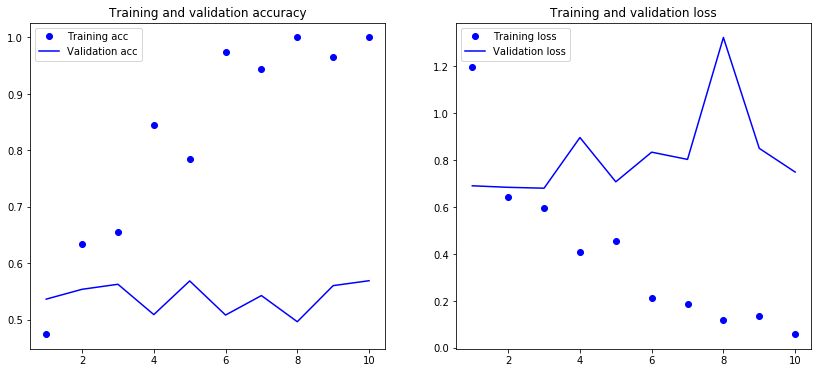

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 6))

plt.subplot(121)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

模型很快就开始过拟合，考虑到训练样本很少，这一点也不奇怪。出于同样的原因，验证精度的波动很大，但似乎达到了接近`60%`。

**注意**，你的结果可能会有所不同。训练样本数太少，所以模型性能严重依赖于你选择的 200 个样本，而样本是随机选择的。如果你得到的结果很差，可以尝试重新选择200个不同的随机样本，你可以将其作为练习（在现实生活中无法选择自己的训练数据）。

你也可以在不加载预训练词嵌入、也不冻结嵌入层的情况下训练相同的模型。在这种情况下，你将会学到针对任务的输入标记的嵌入。如果有大量的可用数据，这种方法通常比预训练词嵌入更加强大，但本例只有200个训练样本。我们来试一下这种方法。

In [19]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 5ms/sample - loss: 0.6922 - acc: 0.5400 - val_loss: 0.6914 - val_acc: 0.5260
Epoch 2/10
200/200 [==============================] - 1s 3ms

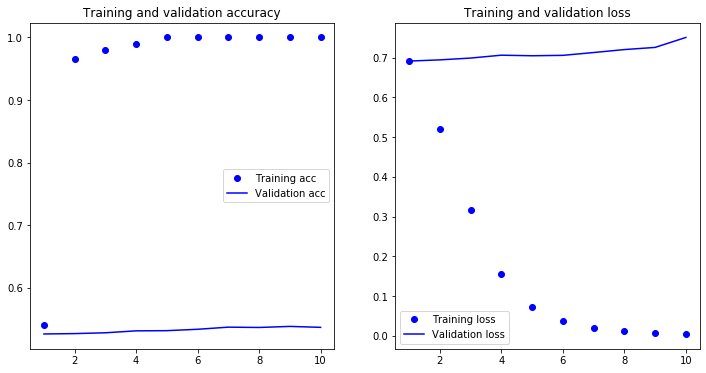

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

验证精度停留在`50%`多一点。因此，在本例中，预训练词嵌入的性能要优于与任务一起学习的嵌入。如果增加样本数量，情况将很快发生变化，你可以把它作为一个练习。

最后，我们在测试数据上评估模型。首先，你需要对测试数据进行分词。

In [21]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

接下来，加载并评估第一个模型。

In [22]:
model.load_weights('./model/pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 53us/sample - loss: 0.7474 - acc: 0.5715


[0.7474173725318909, 0.57152]

测试精度只有`56%` ！处理小数据集可见是非常困难的事情。

### 6.1.4 小结
现在你已经学会了下列内容：
+ 将原始文本转换为神经网络能够处理的格式
+ 使用`Keras`模型的`Embedding`层来学习针对特定任务的标记嵌入
+ 使用预训练词嵌入在小型自然语言处理问题上获得额外的性能提升